In [724]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [725]:
from data_models.basic import LinearData, LinearDataCorrelated, LinearDataTest
from conformal_prediction.basic import SplitConformal, QuantileConformal
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict
import statsmodels.formula.api as smf
import aux_funcs
import json
from scipy.stats import foldnorm
import pandas as pd

In [3]:
std = 0.5
mu = 0

err = np.random.normal(mu, std, size=100000)
# rng = np.random.default_rng()
# x = rng.multivariate_normal([0], np.eye(N=1)*0.05**2, size=10000)

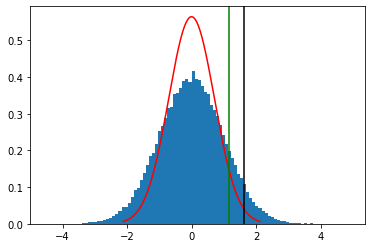

In [6]:
from scipy.stats import norm, foldnorm
var = 1
variance_1 = (std**2)*(var**2)
variance_2 = std**2
sigma = np.sqrt(variance_1 + variance_2)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), color='red')
plt.axvline(norm.ppf(q=0.95, loc=mu, scale=sigma), color='green')
plt.axvline(np.quantile(var*err+err, 0.95, interpolation='lower'), color='black')
plt.hist(var*err+err, density=True, bins=100);

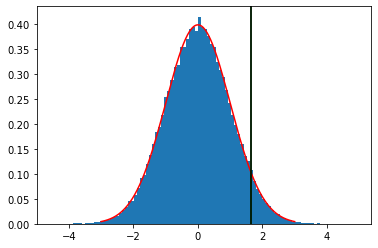

In [7]:
from scipy.stats import norm, foldnorm
var = 1
mu = 0
variance_1 = (std**2)*(var**2)
variance_2 = std**2
sigma = np.sqrt(variance_1) + np.sqrt(variance_2)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), color='red')
plt.axvline(norm.ppf(q=0.95, loc=mu, scale=sigma), color='green')
plt.axvline(np.quantile(var*err+err, 0.95, interpolation='lower'), color='black')
plt.hist(var*err+err, density=True, bins=100);

In [697]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

std=0.5
# weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])
weights=np.array([8, 4, 0.1, -3, 5])

# num_samples = 10000
mu = np.array([0, 0, 0, 0, 0, 
            #    0, 0, 0, 0, 0
              ])
cov_matrix = np.eye(N=len(weights))*std**2

num_samples = 100000

B = 5
model = RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=2)
# model = LinearRegression()
conformal_type = SplitConformal
alpha = 0.05

f = 1

boot_cov = []
boot_size = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)

quant_abs = []
quant_tot = []
quant_imp = []

quant_abs_1 = []
quant_tot_1 = []
quant_imp_1 = []

quant_abs_2 = []
quant_tot_2 = []
quant_imp_2 = []

for i in range(B):

    if i % 5 == 0:
        print(i)


    lineardatacorr = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=std, weights=weights)
    lineardatacorr.X_y_split(y='Y')

    model_all = model
    model_all.fit(lineardatacorr.train_data_X, lineardatacorr.train_data_y)
    model_all = copy.copy(model_all)

    residuals = (lineardatacorr.calib_data_y-model_all.predict(lineardatacorr.calib_data_X)).to_numpy()

    quant_tot.append(np.quantile(residuals, int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))
    quant_abs.append(np.quantile(abs(residuals), int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))

    residuals_abs = abs(lineardatacorr.calib_data_y-model_all.predict(lineardatacorr.calib_data_X)).to_numpy()

    residuals_abs.sort()
    k = int(np.ceil((len(residuals_abs)+1)*(1-0.05)))
    quant_imp.append(abs(residuals_abs)[k-1])

    data_X_train = copy.copy(lineardatacorr.train_data_X)
    data_X_calib = copy.copy(lineardatacorr.calib_data_X)
    data_X_test = copy.copy(lineardatacorr.test_data_X)

    train_pred = model_all.predict(X=lineardatacorr.train_data_X)
    calib_pred = model_all.predict(X=lineardatacorr.calib_data_X)
    test_pred = model_all.predict(X=lineardatacorr.test_data_X)

    train_mse = mean_squared_error(lineardatacorr.train_data_y, train_pred)
    calib_mse = mean_squared_error(lineardatacorr.calib_data_y, calib_pred)
    test_mse = mean_squared_error(lineardatacorr.test_data_y, test_pred)

    print('Linear Train: ', train_mse)
    print('Linear Calibration: ', calib_mse)
    print('Linear Test: ', test_mse)
    print('=====================')
    
    # for variable in lineardatacorr.calib_data_X.columns:
    for variable in ['f' + str(f)]:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j = model
        model_j.fit(data_X_train_j_2, lineardatacorr.train_data_y)

        residuals = (lineardatacorr.calib_data_y-model_j.predict(data_X_calib_j_2)).to_numpy()

        quant_tot_2.append(np.quantile(residuals, int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))
        quant_abs_2.append(np.quantile(abs(residuals), int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))

        residuals_abs = abs(lineardatacorr.calib_data_y-model_j.predict(data_X_calib_j_2)).to_numpy()

        residuals_abs.sort()
        k = int(np.ceil((len(residuals_abs)+1)*(1-0.05)))
        quant_imp_2.append(abs(residuals_abs)[k-1])


        # Train Once
        data_X_calib_j_1 = copy.copy(lineardatacorr.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(lineardatacorr.test_data_X)
        data_X_test_j_1[variable] = 0   

        residuals = (lineardatacorr.calib_data_y-model_all.predict(data_X_calib_j_1)).to_numpy()

        quant_tot_1.append(np.quantile(residuals, int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))
        quant_abs_1.append(np.quantile(abs(residuals), int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))

        residuals_abs = abs(lineardatacorr.calib_data_y-model_all.predict(data_X_calib_j_1)).to_numpy()

        residuals_abs.sort()
        k = int(np.ceil((len(residuals_abs)+1)*(1-0.05)))
        quant_imp_1.append(abs(residuals_abs)[k-1])


0
Linear Train:  0.06228468333632582
Linear Calibration:  0.42355366770245273
Linear Test:  0.40933500676546875
Linear Train:  0.061762684041307435
Linear Calibration:  0.4092238490118086
Linear Test:  0.40520541484515327
Linear Train:  0.06253648168064517
Linear Calibration:  0.4193467928899365
Linear Test:  0.41685137319225785
Linear Train:  0.06198327080716509
Linear Calibration:  0.4132273785108775
Linear Test:  0.4324765112947906
Linear Train:  0.062462987449125866
Linear Calibration:  0.4117376815366969
Linear Test:  0.41189258615895935


What we are doing is estimate the expectation of the quantile values of the residual at the alpha level for a bunch of data simulations.
We can see that the estimated expectation is close to the true underlying quantile value of a true residual distribution which should be a normal distribution over the  mu and std given initially.
We also compare, just in case, that we are calculating the quantile correctly in the  conformal prediction code and that everything matches

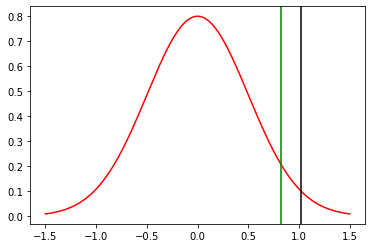

In [698]:
mu = 0
x = np.linspace(mu - 3*std, mu + 3*std, 1000)
plt.plot(x, norm.pdf(x, mu, std), color='red')
plt.axvline(norm.ppf(q=0.95, loc=mu, scale=std), color='green')
plt.axvline(np.mean(quant_tot), color='black')
# plt.hist(residuals, bins=70, density=True);

In [699]:
print(norm.ppf(q=0.95, loc=mu, scale=std))
print(np.mean(quant_tot))

0.8224268134757361
1.0208361591126243


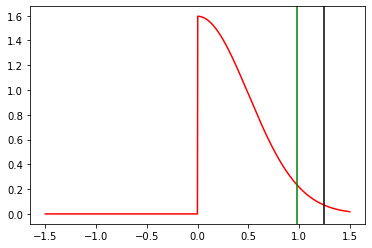

In [700]:
x = np.linspace(mu - 3*std, mu + 3*std, 1000)
plt.plot(x, foldnorm.pdf(x, c=mu, scale=std), color='red')
plt.axvline(foldnorm.ppf(q=0.95, c=mu, scale=std), color='green')
plt.axvline(np.mean(quant_abs), color='black')
# plt.hist(abs(residuals), bins=50, density=True);

In [701]:
print(foldnorm.ppf(q=0.95, c=mu, scale=std))
print(np.mean(quant_abs))

0.9799819922700269
1.2438040581932455


In [702]:
np.mean(quant_imp)

1.2438040581932455

Let's now check-out the distributions that are generated through the removal of one of the variables and once again see if we are able to reach through simulation the true underlying values, for both train once and train twice

### Train Once

In [703]:
std

0.5

In [704]:
weights[f-1]**2

64.0

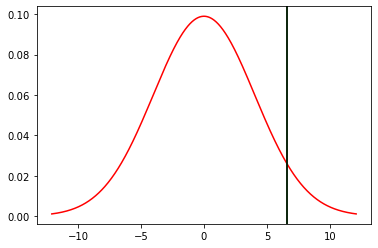

In [705]:
sigma = weights[f-1]**2*std**2+std**2

x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 1000)
plt.plot(x, norm.pdf(x, mu, np.sqrt(sigma)), color='red')
plt.axvline(norm.ppf(q=0.95, loc=mu, scale=np.sqrt(sigma)), color='green')
plt.axvline(np.mean(quant_tot_1), color='black')
# plt.hist(residuals, bins=70, density=True);

In [706]:
print(norm.ppf(q=0.95, loc=mu, scale=np.sqrt(sigma)))
print(np.mean(quant_tot_1))

6.6306169493532385
6.571785249897042


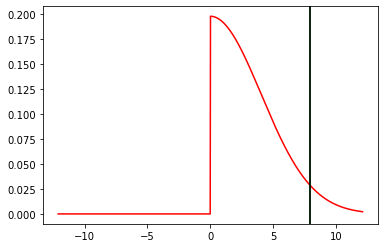

In [707]:
mu = 0
x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 1000)
plt.plot(x, foldnorm.pdf(x, c=mu, scale=np.sqrt(sigma)), color='red')
plt.axvline(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)), color='green')
plt.axvline(np.mean(quant_abs_1), color='black')
# plt.hist(abs(residuals), bins=50, density=True);

In [708]:
print(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)))
print(np.mean(quant_abs_1))

7.900867410372073
7.910415549070313


In [709]:
np.mean(quant_imp_1)

7.910415549070313

### Train twice

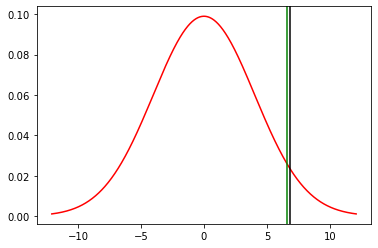

In [710]:
mu = 0
x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 1000)
plt.plot(x, norm.pdf(x, mu, np.sqrt(sigma)), color='red')
plt.axvline(norm.ppf(q=0.95, loc=mu, scale=np.sqrt(sigma)), color='green')
plt.axvline(np.mean(quant_tot_2), color='black')
# plt.hist(residuals, bins=70, density=True);

In [711]:
print(norm.ppf(q=0.95, loc=mu, scale=np.sqrt(sigma)))
print(np.mean(quant_tot_2))

6.6306169493532385
6.833980950192958


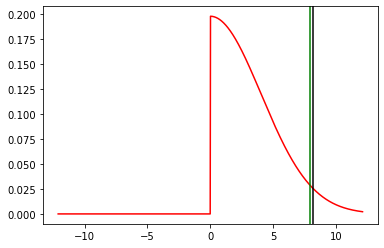

In [712]:
x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 1000)
plt.plot(x, foldnorm.pdf(x, c=mu, scale=np.sqrt(sigma)), color='red')
plt.axvline(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)), color='green')
plt.axvline(np.mean(quant_abs_2), color='black')
# plt.hist(abs(residuals), bins=50, density=True);

In [713]:
print(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)))
print(np.mean(quant_abs_2))

7.900867410372073
8.154726699641767


In [714]:
np.mean(quant_imp_2)

8.154726699641767

### Now putting everything together...

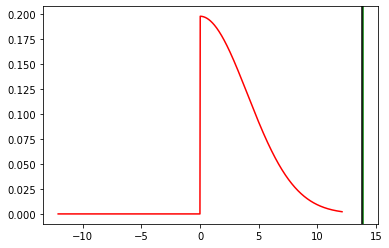

In [721]:
x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 1000)
plt.plot(x, foldnorm.pdf(x, c=mu, scale=np.sqrt(sigma)), color='red')
plt.axvline(2*(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)) - foldnorm.ppf(q=0.95, c=mu, scale=std)), color='green')
plt.axvline(2*(np.mean(np.array(quant_abs_2) - np.array(quant_abs))), color='black')
# plt.hist(residuals, bins=70, density=True);

In [716]:
print(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)) - foldnorm.ppf(q=0.95, c=mu, scale=std))
print(np.mean(np.array(quant_abs_2)) - np.mean(np.array(quant_abs)))

6.9208854181020465
6.910922641448521


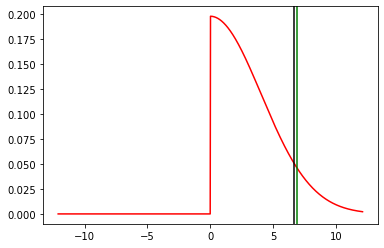

In [720]:
x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 1000)
plt.plot(x, foldnorm.pdf(x, c=mu, scale=np.sqrt(sigma)), color='red')
plt.axvline(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)) - foldnorm.ppf(q=0.95, c=mu, scale=std), color='green')
plt.axvline(np.mean(np.array(quant_abs_1) - np.array(quant_abs)), color='black')
# plt.hist(residuals, bins=70, density=True);

In [718]:
print(foldnorm.ppf(q=0.95, c=mu, scale=np.sqrt(sigma)) - foldnorm.ppf(q=0.95, c=mu, scale=std))
print(np.mean(np.array(quant_abs_1)) - np.mean(np.array(quant_abs)))

6.9208854181020465
6.6666114908770675


### Making sure the asymptotic confidence interval is correct

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

std=1
# weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])
weights=np.array([8, 4, 0.1, -3, 5])

# num_samples = 10000
mu = np.array([0, 0, 0, 0, 0, 
            #    0, 0, 0, 0, 0
              ])
cov_matrix = np.eye(N=len(weights))*std**2

num_samples = 10000

B = 1000
# model = RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=2)
model = LinearRegression()
conformal_type = SplitConformal
alpha = 0.05

f = 1

size_all = []
size_j = []

for i in range(B):

    if i % 50 == 0:
        print(i)

    lineardatacorr = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=std, weights=weights)
    lineardatacorr.X_y_split(y='Y')

    model_all = model
    model_all.fit(lineardatacorr.train_data_X, lineardatacorr.train_data_y)
    model_all = copy.copy(model_all)

    residuals = (lineardatacorr.calib_data_y-model_all.predict(lineardatacorr.calib_data_X)).to_numpy()

    size_all.append(2*np.quantile(residuals, int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))

    data_X_train = copy.copy(lineardatacorr.train_data_X)
    data_X_calib = copy.copy(lineardatacorr.calib_data_X)
    data_X_test = copy.copy(lineardatacorr.test_data_X)
    
    # for variable in lineardatacorr.calib_data_X.columns:
    for variable in ['f' + str(f)]:

        # Train Once
        data_X_calib_j_1 = copy.copy(lineardatacorr.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(lineardatacorr.test_data_X)
        data_X_test_j_1[variable] = 0   

        residuals = (lineardatacorr.calib_data_y-model_all.predict(data_X_calib_j_1)).to_numpy()

        size_j.append(2*np.quantile(residuals, int(np.ceil((len(residuals)+1)*(1-0.05)))/len(residuals), interpolation='lower'))

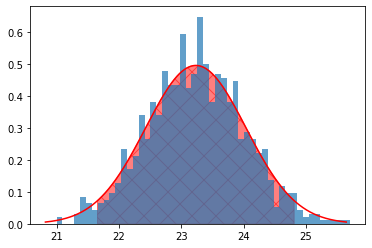

In [818]:
from scipy.stats import pearsonr, t

pearson = pearsonr(size_all, size_j)[0]
mean_all = np.mean(size_all)
std_all = np.std(size_all, ddof=1)/np.sqrt(1)
mean_j = np.mean(size_j)
std_j = np.std(size_j, ddof=1)/np.sqrt(1)
mean = mean_j - mean_all
std = std_all+std_j - 2*pearson
h = std * t.ppf((1 + 0.95) / 2., B-1)
x = np.linspace(mean - 3*std, mean + 3*std, 1000)
plt.plot(x, norm.pdf(x, mean, std), color='red')
plt.hist(np.array(size_j)-np.array(size_all), bins=50, density=True, alpha=0.7);
plt.fill_between(
        x= x, 
        y1= norm.pdf(x, mean, std), 
        where= (mean-h < x)&(x < mean+h),
        hatch='x', alpha=0.5, color='red')